# GAN for album cover generation

### Summary

This project creates a Generative Adversarial Network (GAN) for album cover generation based on the Spotify dataset.
It is based on [this paper](https://ryanmcconville.com/publications/AlbumCoverGenerationFromGenreTags.pdf) and the ultimate objective is to generate album images based on music genres.

There will be some intermediate steps on the process:
1 - Generate a data set
2 - Create a genre classifier
3 - Create an album image GAN
4 - Create a GAN that generates albums based on genre

In [1]:
!pip3 install spotipy
!pip3 install torch
!pip3 install torchvision
!pip3 install matplotlib
!pip3 install numpy

     |████████████████████████████████| 153kB 8.0MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import spotipy
import time
import random
from spotipy.oauth2 import SpotifyClientCredentials

## Loading spotify credentials

You need to configure your spotify credentials as a json file.\

Your json file should be called **spotify_credentials.json** and look like this:

```json
{
    "client_id": "your_client_id",
    "client_secret": "your_client_secret"
}
```

More details on how to use json files as configuration files can be found [here](https://martin-thoma.com/configuration-files-in-python/#:~:text=configuration%20handling%3A%20cfg_load-,Python%20Configuration%20File,to%20avoid%20uploading%20it%20accidentally)

In [4]:
import json

with open("spotify_credentials.json") as json_data_file:
    data = json.load(json_data_file)

client_id = data["client_id"]
client_secret = data["client_secret"]

In [5]:
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Creating a list of images

There's no real api to get all album images of a `genre` in Spotify.\
We need to go around that limitation by assuming that some spotify categories behave as genres.

From there we can use:
- Get a list of categories
- Get all the playlists for a category
- Get all songs for a playlist
- Get an album image for every song

In [6]:
def get_playlists(
    category,
    country = "US"
):
    playlists = list()
    
    offset = 0
    while True: #get more playlists
        playlistResponse = sp.category_playlists(category, limit = 20, offset = offset, country = country)['playlists']
        playlists.extend(playlistResponse['items'])
        
        if playlistResponse['next'] == None:
            break
        else:
            offset += 20
    
    return playlists

In [7]:
def get_tracks(playlist):
    tracks = list()
    
    offset = 0
    while True: #get more playlists
        tracksResponse = sp.playlist_tracks(playlist['id'], limit=100, offset = offset)
        tracks.extend(tracksResponse['items'])
        
        if tracksResponse['next'] == None:
            break
        else:
            offset += 100
    
    return tracks

In [8]:
def get_album_images(category):
    print ("Downloading playlists")
    playlists = get_playlists(category)
    print ("Downloaded {} playlists".format(len(playlists)))
    
    print ("Downloading tracks")
    tracks = list()
    for playlist in playlists:
        tracks.extend(get_tracks(playlist))
    print ("Downloaded {} tracks".format(len(tracks)))
    
    allImages = set()
    for track in tracks:
        trackData = track['track']
        if (trackData == None): continue
        
        album = trackData['album']        
        if (album == None): continue
        
        trackImages = album['images']
        if (trackImages == None or len(trackImages) == 0): continue
        
        imageUrl = trackImages[0]['url']
        
        if (imageUrl != None):
            allImages.add(imageUrl)
    
    return allImages

## Downloading all the images

arguments of the function download_url:

<ul>
<li>url (str): URL to download file from</li>
<li>root (str): Directory to place downloaded file in</li>
<li>filename (str, optional): Name to save the file under. If None, use the basename of the URL</li>
</ul>


In [9]:
import urllib
import os

def download_url(url, root, filename=None):
    #root = os.path.expanduser(root)
    if not filename:
        filename = os.path.basename(url)
    fpath = os.path.join(root, filename  + "." + "png")

    os.makedirs(root, exist_ok=True)

    try:
        print('Downloading ' + url + ' to ' + fpath)
        urllib.request.urlretrieve(url, fpath)
    except (urllib.error.URLError, IOError) as e:
        if url[:5] == 'https':
            url = url.replace('https:', 'http:')
            print('Failed download. Trying https -> http instead.'
                    ' Downloading ' + url + ' to ' + fpath)
            urllib.request.urlretrieve(url, fpath)

In [10]:
categories = [
    "rock",
    "pop",
    "classical",
    "hiphop",
    "country",
    "latin",
    "edm_dance",
    "jazz"
]

In [11]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#download all at once --> but it is ineffective if you have poor internet connection
"""for category in categories:
    print("-------------------------------")
    print("Downloading {}".format(category))
    print("-------------------------------")
    imageUrls = get_album_images(category)
    
    for url in imageUrls:
        download_url(url, "/content/gdrive/MyDrive/projects/images/" + category)"""


In [20]:
category = "jazz"
print("-------------------------------")
print("Downloading {}".format(category))
print("-------------------------------")
imageUrls = get_album_images(category)

for url in imageUrls:
    download_url(url, "/content/gdrive/MyDrive/projects/images/" + category)

-------------------------------
-------------------------------
Downloaded 62 playlists
Downloaded 4715 tracks


Defined data set
Defined data loader
Defined device


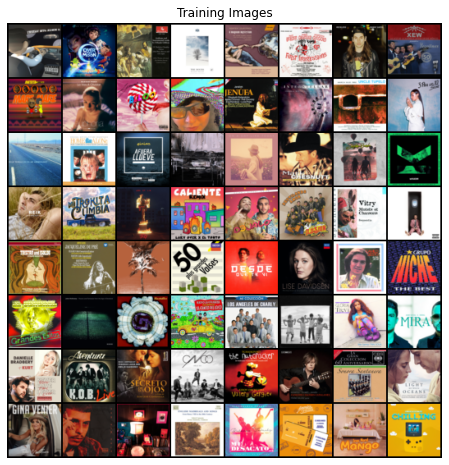

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create the dataset
dataset = dset.ImageFolder(root="~/images",
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

print ("Defined data set")
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 128,
                                         shuffle=True, num_workers = 2)

print ("Defined data loader")
# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print ("Defined device")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))